## Example 8 - Spline Tension

Apply spline tension to interpolaton, gradient, derivative, or smoothing routines to reduce the occurance of undershoot / overshoot inconsistencies in the solution.

The values to determine the degree of tension is stored in `sigma`. Using the routine `get_spline_tension_factors` will determine the smallest tension factor such that the spline preserves the local shape properties (monotonicity and convexity) of the data. If `sigma` is zero everywhere, then no tension is active.

We walk through a number of routines that we have explored in previous notebooks, but in this case demonstrating the use of tensioned splines.

#### Contents

- [Smoothing with tension](#Smoothing-with-tension)
- [Interpolation with tension](#Interpolation-with-tension)
- [Gradients with tension](#Gradients-with-tension)

In [1]:
import stripy as stripy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
xmin = 0.0
xmax = 10.0
ymin = 0.0
ymax = 10.0
extent = [xmin, xmax, ymin, ymax]

spacingX = 0.5
spacingY = 0.5

mesh = stripy.cartesian_meshes.elliptical_mesh(extent, spacingX, spacingY, refinement_levels=3)

In [3]:
def analytic(lons, lats, k1, k2):
     return  np.cos(k1*lons) * np.sin(k2*lats) 

def analytic_noisy(lons, lats, k1, k2, noise, short):
     return  np.cos(k1*lons) * np.sin(k2*lats) + short * (np.cos(k1*5.0*lons) * np.sin(k2*5.0*lats)) +  noise * np.random.random(lons.shape)

data   = analytic(mesh.x, mesh.y, 1.0, 1.0)
data_n = analytic_noisy(mesh.x, mesh.y, 1.0, 1.0, 0.1, 0.0)

In [4]:
# get tension factors from the data
sigma   = mesh.get_spline_tension_factors(data, tol=1e-6)
sigma_n = mesh.get_spline_tension_factors(data_n, tol=1e-6)

assert sigma.any(), "if this raises an error, then no tension is active"
assert sigma_n.any(), "if this raises an error, then no tension is active"


### Smoothing with tension

Tension is applied simply by supplying `sigma`. It's effect is most noticible near the poles where there are edge artefacts in the solution.

In [5]:
stripy_smoothed,  dds, err = mesh.smoothing(data, np.ones_like(data_n), 10.0, 0.1, 0.01)
stripy_smoothed2, dds, err = mesh.smoothing(data, np.ones_like(data_n), 10.0, 0.1, 0.01, sigma=sigma)


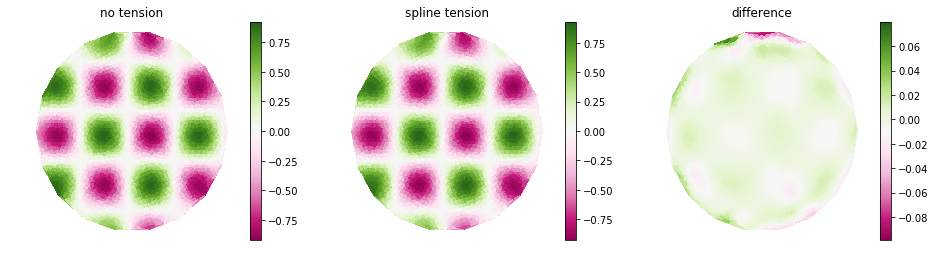

In [6]:
def axes_mesh_field(fig, ax, mesh, field, label):
    ax.axis('off')
    ax.set_title(str(label))
    im = ax.tripcolor(mesh.x, mesh.y, mesh.simplices, field, cmap="PiYG", label=label)
    fig.colorbar(im, ax=ax)


fig, axes = plt.subplots(1,3, figsize=(16,4))

axes_mesh_field(fig, axes[0], mesh, stripy_smoothed, "no tension")
axes_mesh_field(fig, axes[1], mesh, stripy_smoothed2, "spline tension")
axes_mesh_field(fig, axes[2], mesh, stripy_smoothed - stripy_smoothed2, "difference")


### Interpolation with tension

Only applies to cubic interpolation. The effect of supplying a non-negative `sigma` is to produce a _more linear_ interpolation. For regions that lie outside the hull, cubic extrapolation produces wild oscillations in the solution which can be mitigated with spline tension.

In [7]:
# set up a discontinuous mesh and offset

mask_points = mesh.x < 5.0
cmesh = stripy.Triangulation(mesh.x[mask_points]+5, mesh.y[mask_points]+5)

cdata   = analytic(cmesh.x, cmesh.y, 1.0, 1.0)
csigma  = cmesh.get_spline_tension_factors(cdata, tol=1e-6)

In [8]:
# interpolate back to original mesh

grid_z1, ierr = cmesh.interpolate_cubic(mesh.x, mesh.y, cdata) # no tension
grid_z2, ierr = cmesh.interpolate_cubic(mesh.x, mesh.y, cdata, sigma=csigma) # tension

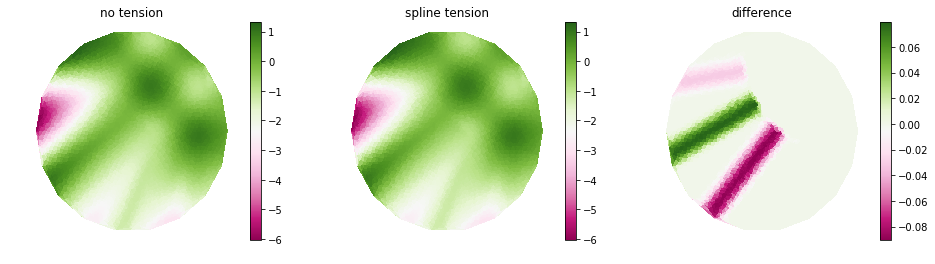

In [9]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

axes_mesh_field(fig, axes[0], mesh, grid_z1, "no tension")
axes_mesh_field(fig, axes[1], mesh, grid_z2, "spline tension")
axes_mesh_field(fig, axes[2], mesh, grid_z1 - grid_z2, "difference")

### Gradients with tension

Pass `sigma` to the following routines that involve derivatives:

- `gradient_lonlat`
- `gradient_xyz`
- `derivatives_lonlat`

Again, the largest difference is visible at the poles.

In [10]:
dx1, dy1 = mesh.gradient(data, nit=5, tol=1e-6) # no tension
dx2, dy2 = mesh.gradient(data, nit=5, tol=1e-6, sigma=sigma) # tension

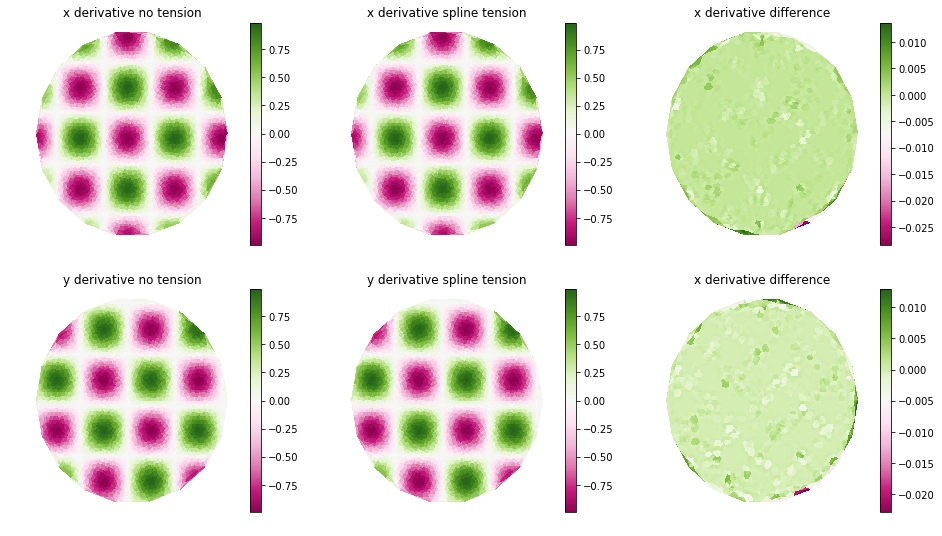

In [11]:
fig, axes = plt.subplots(2,3, figsize=(16,9))

axes_mesh_field(fig, axes[0,0], mesh, dx1, "x derivative no tension")
axes_mesh_field(fig, axes[0,1], mesh, dx2, "x derivative spline tension")
axes_mesh_field(fig, axes[0,2], mesh, dx1 - dx2, "x derivative difference")

axes_mesh_field(fig, axes[1,0], mesh, dy1, "y derivative no tension")
axes_mesh_field(fig, axes[1,1], mesh, dy2, "y derivative spline tension")
axes_mesh_field(fig, axes[1,2], mesh, dy1 - dy2, "x derivative difference")

The next notebook is [Ex9-Voronoi-Diagram](Ex9-Voronoi-Diagram.ipynb)